# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# fix random seed for reproducibility
seed = 7

captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root_path = pathlib.Path(captions_root)

human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

None


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [3]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2

from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold

%matplotlib inline 

def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}


fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 999995
embedding dimension : (300,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


0             two acorns lying ground next oak leaves.
1    three acorns flat surface. one acorn missing c...
2    five acorns arranged circle black background. ...
3    two cocktails brown wooden table. cocktail fro...
4                  three shelves full bottles whiskey.
Name: caption, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64
Label distribution:  label
-1    163
 0    420
 1    317
Name: label, dtype: int64
max_seq_len 38

TRAIN size: 770 	 VAL size: 130
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [10 19 36 51 53]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [873 875 877 881 885]
Train label distribution:  label
-1    139
 0    360
 1    271
Name: label, dtype: int64
Val label distribution:  label
-1    24
 0    60
 1    46
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 300)         

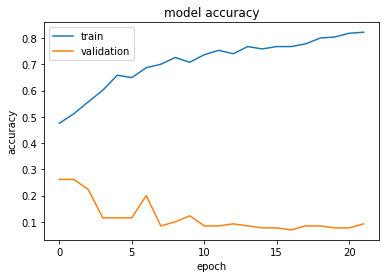

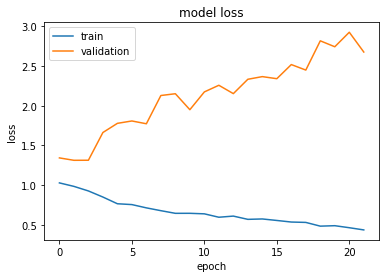

Time passed for training 0.8610987027486166

TRAIN size: 770 	 VAL size: 130
TRAIN[:5]: [0 2 3 4 5] 	 VAL[:5]: [ 1 22 31 34 35]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [849 855 872 890 891]
Train label distribution:  label
-1    139
 0    360
 1    271
Name: label, dtype: int64
Val label distribution:  label
-1    24
 0    60
 1    46
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None
bes

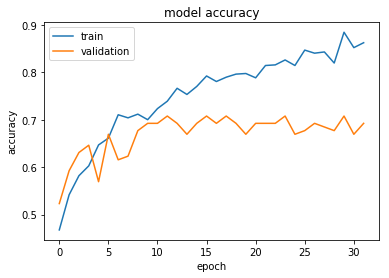

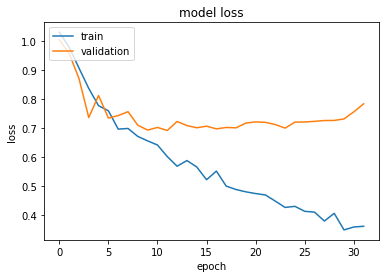

Time passed for training 1.2395688096682231

TRAIN size: 772 	 VAL size: 128
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [27 44 45 62 65]
TRAIN[-5:]: [893 894 895 897 899] 	 VAL[-5:]: [870 886 887 896 898]
Train label distribution:  label
-1    140
 0    360
 1    272
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    60
 1    45
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None
bes

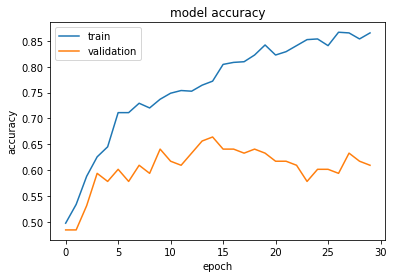

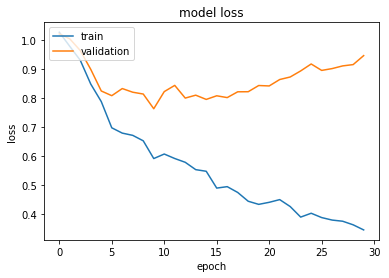

Time passed for training 1.181078883012136

TRAIN size: 772 	 VAL size: 128
TRAIN[:5]: [0 1 2 3 6] 	 VAL[:5]: [ 4  5  8 14 15]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [876 879 880 892 893]
Train label distribution:  label
-1    140
 0    360
 1    272
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    60
 1    45
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None
best

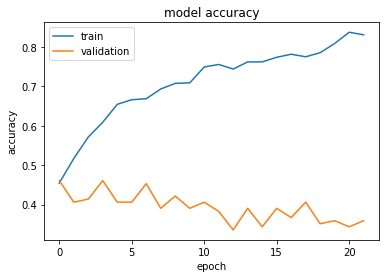

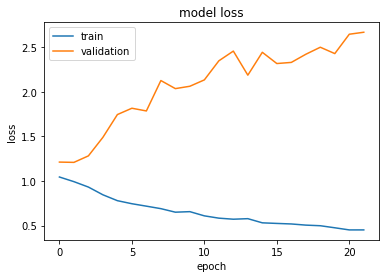

Time passed for training 0.9470037778218587

TRAIN size: 772 	 VAL size: 128
TRAIN[:5]: [1 4 5 6 7] 	 VAL[:5]: [ 0  2  3  9 17]
TRAIN[-5:]: [893 895 896 897 898] 	 VAL[-5:]: [868 874 888 894 899]
Train label distribution:  label
-1    140
 0    360
 1    272
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    60
 1    45
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None
bes

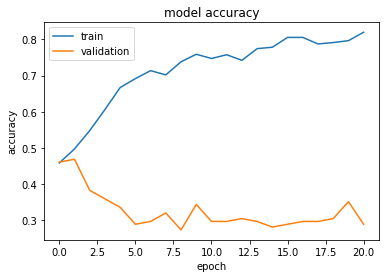

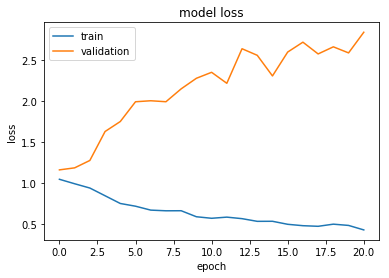

Time passed for training 0.8676974693934123

TRAIN size: 772 	 VAL size: 128
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [13 24 26 32 39]
TRAIN[-5:]: [894 896 897 898 899] 	 VAL[-5:]: [860 882 883 884 895]
Train label distribution:  label
-1    140
 0    360
 1    272
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    60
 1    45
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_6 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None
bes

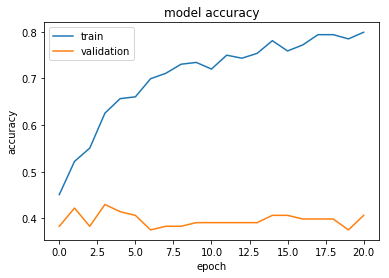

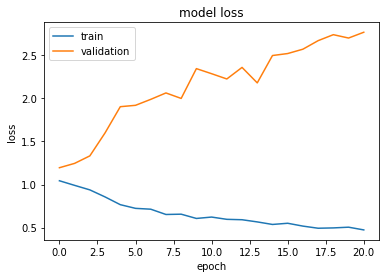

Time passed for training 0.8480185985565185

TRAIN size: 772 	 VAL size: 128
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [ 6  7 11 12 16]
TRAIN[-5:]: [894 895 896 898 899] 	 VAL[-5:]: [865 867 878 889 897]
Train label distribution:  label
-1    140
 0    360
 1    272
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    60
 1    45
Name: label, dtype: int64
final_activation softmax
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_7 (GRU)                  (None, 38)                38646     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 117       
Total params: 38,763
Trainable params: 38,763
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import nltk
from nltk.corpus import stopwords
from keras.layers.core import  ActivityRegularization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers import Activation, TimeDistributed, Embedding, GRU, Bidirectional, LSTM
from sklearn.metrics import f1_score
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

stop_words = set(stopwords.words('english'))

def get_word_embedding(word):
    word = word.lower()
    if word in wordToVec:
        return wordToVec[word]
    else:
        return np.zeros(embedding_dimension,)
    
def get_sequence_embedding(words, max_seq_len):
    if len(words) <= max_seq_len:
        # Add padding
        x_seq = np.array([get_word_embedding(word) for word in words])
        x_seq = np.lib.pad(x_seq, ((0,max_seq_len-x_seq.shape[0]),(0,0)), 'constant')
    else:
        x_seq = []
        for i in range(max_seq_len):
            x_seq.append(get_word_embedding(words[i]))
        x_seq = np.array(x_seq)
    return x_seq
        
def convert_index_to_one_hot(y_train_index, num_of_classes):
    y_train = np.zeros((y_train_index.shape[0],num_of_classes))
    y_train[range(y_train_index.shape[0]),y_train_index] = 1
    return y_train


def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename

def get_words_withoutstopwords(words):
    words_without_stopwords = []
    for word in words:
        if word not in stop_words:
            words_without_stopwords.append(word)
    return words_without_stopwords

def load_dataset_StratifiedKFold(dfKFold, max_seq_len):
    sentences = []
    label_index = []
    num_of_classes = 0
    class_to_index = {}
    index_to_class = {}
    for index, row in dfKFold.iterrows():
        caption = row['caption']
        label = row['label']
        sentence = caption
        words = sentence.split(" ")
        words = get_non_stop_words(words)
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)


def get_non_stop_word_count(words):
    count = 0
    for word in words:
        if word not in stop_words:
            count += 1
    return count


def get_non_stop_words(words):
    non_stop_words = []
    for word in words:
        if word not in stop_words:
            non_stop_words.append(word)
    return non_stop_words

def change_label_str_to_int(labelStr):
    if labelStr == "negative":
        return -1
    elif  labelStr == "neutral":
        return 0
    elif  labelStr == "positive":
        return 1

def change_label_str_to_int_binary(labelStr):
    """this is only for binary classification, negative sentiment has value 0, positive sentiment has value 1"""
    if labelStr == "negative":
        return 0
    elif  labelStr == "neutral":
        raise "Neutral Should not exist"
    elif  labelStr == "positive":
        return 1
    else:
        raise labelStr+ " Should not exist"

def get_df_for_binary_classification():
    df = pd.read_csv(dataset_path, header=0, sep="|")
    # Doing only binary classification
    df = df[(df.label == "negative") | (df.label == "positive")]
    df = df.reset_index()
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int_binary(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    return df


def build_model(isBinaryClassification, isF1Enabled, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    dropout = 0.5
    recurrent_dropout = 0.5
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    #model.add(GRU(max_seq_len,return_sequences=True, recurrent_dropout=recurrent_dropout))
    #model.add(Dropout(dropout))
    model.add(GRU(max_seq_len, dropout=0.3, recurrent_dropout=0.3))
    #model.add(Dropout(0.3))
    
    
    model.add(Dense(num_of_classes, activation=final_activation))
    
    if isF1Enabled:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        
    if isBinaryClassification:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    print(model.summary())
    return model


def train_StratifiedKFold(isBinaryClassification,isF1Enabled):
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    df = pd.read_csv(dataset_path, header=0, sep="|")
    df["label"] = df["label"].apply(lambda x: change_label_str_to_int(x))
    df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
    print(df['caption'].head(5))
    print(df['label'].head(5))
    # Doing only binary classification
    if isBinaryClassification:
        df = get_df_for_binary_classification()
    
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cv_accuracies = []
    cv_f1s = []
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("TRAIN[:5]:", train_indices[:printCnt], "\t VAL[:5]:", val_indices[:printCnt])
        print("TRAIN[-5:]:", train_indices[-printCnt:], "\t VAL[-5:]:", val_indices[-printCnt:])
        
        X_train, X_val = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        
        dfVal= pd.concat([X_val, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfVal.groupby('label').label.count())
        
        if isBinaryClassification:
            final_activation ='sigmoid'
        else:
            final_activation ='softmax'
        
        print("final_activation",final_activation)
        model = build_model(isBinaryClassification,
                            isF1Enabled,
                            max_seq_len,
                            num_of_classes, 
                            embedding_dim=300, 
                            hidden_layer_dim=40, 
                            dropout=0.5, 
                            recurrent_dropout=0.5,# 0.3
                            final_activation=final_activation
                            )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=5, 
                                  min_lr=0.001)
        
        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=20)
        
        callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=16,# 64 seems fine, 32 is better 
                      epochs=100, 
                      verbose=0, 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if isF1Enabled:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,"model/", isF1Enabled)
        
        end = time.time()
        print("Time passed for training", (end-start)/60)
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 7
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
isBinaryClassification = False
isF1Enabled = False
history = train_StratifiedKFold(isBinaryClassification, isF1Enabled) 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


## Determien Vocabulary size - unique word counts

In [5]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    

Voc size:  2827


# New Train on Twitter dataset, validate on OASIS images caption dataset

1,578,628 Tweets with positive/negative sentiments - labelled data

In [6]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')



In [7]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()


# twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Sentiment_Analysis_Dataset.csv" 
# cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv" 
# df = pd.read_csv(twitter_dataset_path, error_bad_lines=False)
# df = df[['SentimentText','Sentiment']]
# df["SentimentText"] = df["SentimentText"].apply(lambda x: tokenizer(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(x))
# df["SentimentText"] = df["SentimentText"].apply(lambda x: " ".join(get_words_withoutstopwords(x.lower().split())))
# df.columns = ['caption','label']
# df = df.dropna()
# df.to_csv(cleaned_twitter_dataset_path, index=False)
# print("df.shape", df.shape)
# print("df.head()", df.head())

# fig = plt.figure(figsize=(8,5))
# ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
# ax.set(xlabel='Labels');

## Train on Twitter dataset, validate on Image captions

                                             caption  label
0                                     sad apl friend      0
1                            missed new moon trailer      0
2                                   omg already 7 30      1
3  omgaga sooo gunna cry dentist since 11 suposed...      0
4                               think mi bf cheating      0
dfTwitter.count() caption    10000
label      10000
dtype: int64
Label distribution:  label
0    163
1    317
Name: label, dtype: int64
max_seq_len_captions 27
max_seq_len_tweets 30
max_seq_len 30
final_activation sigmoid
Train label distribution:  label
0    5139
1    5271
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    24
1    46
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 300)         0         
___________________________________________________

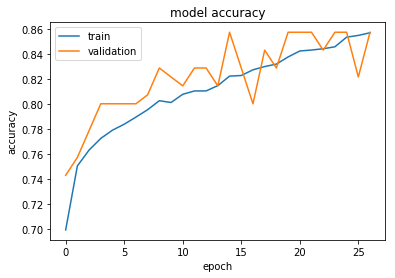

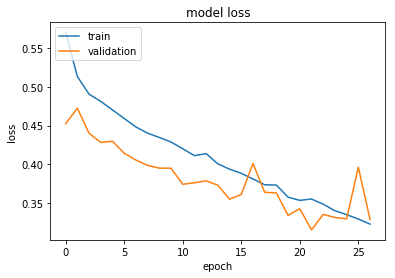

Time passed for training 10.025718061129252
Train label distribution:  label
0    5139
1    5271
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    24
1    46
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 30)          29790     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 35,342
Trainable params: 35,342
Non-trainable p

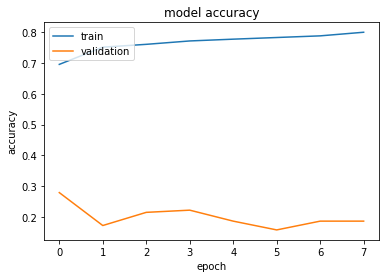

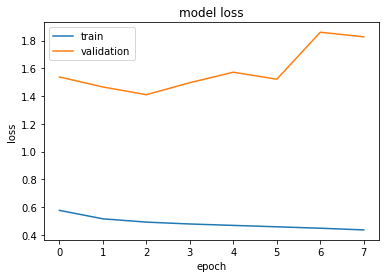

Time passed for training 13.03937703371048
Train label distribution:  label
0    5140
1    5272
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, None, 30)          29790     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 62        
Total params: 35,342
Trainable params: 35,342
Non-trainable pa

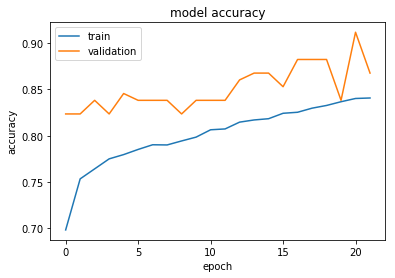

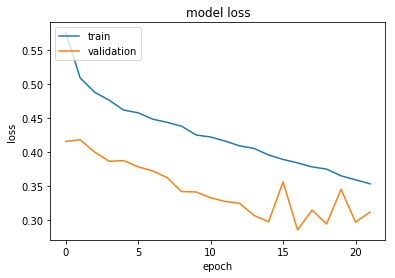

Time passed for training 21.43459438085556
Train label distribution:  label
0    5140
1    5272
Name: label, dtype: int64
num_of_classes 2
Val label distribution:  label
0    23
1    45
Name: label, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, None, 300)         0         
_________________________________________________________________
gru_7 (GRU)                  (None, None, 30)          29790     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 62        
Total params: 35,342
Trainable params: 35,342
Non-trainable pa

KeyboardInterrupt: 

In [8]:
cleaned_twitter_dataset_path = "/home/elkhand/datasets/twitter-sentiment/Cleaned_Sentiment_Analysis_Dataset.csv"

import tensorflow as tf
tf.Session(config=tf.ConfigProto(log_device_placement=True))


def build_model(isBinaryClassification, max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    #, dropout=dropout, recurrent_dropout=recurrent_dropout
    model.add(GRU(max_seq_len,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    #model.add(GRU(max_seq_len // 2,return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(0.2))
    model.add(GRU(max_seq_len, dropout=dropout, recurrent_dropout=recurrent_dropout)) 
#     model.add(Dropout(dropout))
    
    
    model.add(Dense(num_of_classes, activation=final_activation))

    if isBinaryClassification:
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1, recall, precision])#
    else:
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy', f1, recall, precision])#
    print(model.summary())
    return model

def twitter_train_StratifiedKFold(isBinaryClassification):
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    
    dfTwitter = pd.read_csv(cleaned_twitter_dataset_path, header=0)
    print(dfTwitter.head())
    dfTwitter.columns = ['caption', 'label']
    dfTwitter = dfTwitter.dropna()
    dfTwitterPos = dfTwitter[dfTwitter.label == 1]
    dfTwitterPos = dfTwitterPos[:5000]
    dfTwitterNeg = dfTwitter[dfTwitter.label == 0]
    dfTwitterNeg = dfTwitterNeg[:5000]
    dfTwitter =  pd.concat([dfTwitterNeg, dfTwitterPos]) 

    print("dfTwitter.count()",dfTwitter.count())

    dfCaption = pd.read_csv(dataset_path, header=0, sep="|")
    # Doing only binary classification
    if isBinaryClassification:
        dfCaption = get_df_for_binary_classification()
    

    print("Label distribution: ",dfCaption.groupby('label').label.count())
    max_seq_len_captions = int(dfCaption['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len_captions", max_seq_len_captions)
    
    max_seq_len_tweets = int(dfTwitter['caption'].map(lambda x: len(x.split())).max())
    print("max_seq_len_tweets", max_seq_len_tweets)
    
    max_seq_len = max(max_seq_len_captions,max_seq_len_tweets)
    print("max_seq_len", max_seq_len)
    
    
    
    X = dfCaption['caption']
    y = dfCaption['label']
    
 
    
    if isBinaryClassification:
        final_activation ='sigmoid'
    else:
        final_activation ='softmax'
    print("final_activation",final_activation)
    
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cv_accuracies = []
    cv_f1s = []
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_caption, y_val_caption = y[train_indices], y[val_indices]
        
        dfCaptionTrain = pd.concat([X_train_caption, y_train_caption], axis=1) 
        
        dfTweetCaptionTrain = pd.concat([dfTwitter, dfCaptionTrain])               
        
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTweetCaptionTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes)
        print("Train label distribution: ",dfTweetCaptionTrain.groupby('label').label.count())
        print("num_of_classes",num_of_classes)
        
        dfCaptionVal = pd.concat([X_val_caption, y_val_caption], axis=1) 
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfCaptionVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfCaptionVal.groupby('label').label.count())       

        model = build_model(isBinaryClassification,
                               max_seq_len,
                                num_of_classes, 
                                embedding_dim=300, 
                                hidden_layer_dim=40, 
                                dropout=0.2, 
                                recurrent_dropout=0.2,# 0.3
                                final_activation=final_activation
                                )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=5, 
                                      min_lr=0.001)

        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5)    
        callbacks_list = [ checkpoint, early_stopping, reduce_lr]  #
        history = model.fit(x=X_train,
                          y=y_train, 
                          batch_size=32,# 64 seems fine, 32 is better 
                          epochs=100, 
                          verbose=1, 
                          validation_data = (X_val, y_val),
                          shuffle=True,
                          callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        val_f1_list = history.history['val_f1']
        best_val_acc =  max(val_acc_list)
        best_f1 =  max(val_f1_list)
        print("best_val_acc: ", best_val_acc)
        print("best_f1: ", best_f1)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        cv_accuracies.append(best_val_acc)
        cv_f1s.append(best_f1)
        plot_model_accuracy(history, "model/")
        end = time.time()
        print("Time passed for training", (end-start)/60)
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 7
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
isBinaryClassification = True
#history = twitter_train_StratifiedKFold(isBinaryClassification) 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tf = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.list_devices()